# Module 3: Water flow in roots

by Daniel Leitner, Andrea Schnepf 

## Theory


Roughly based on Roose and Fowler (2004) and Doussan et al. (2006).


The axial water flux in a xylem is given by 
\begin{eqnarray} 
q_z = - k_z \left( \frac{\partial \psi_r}{\partial z} - e_z \cdot v \right), \label{axialflux}
\end{eqnarray}
with units [cm$^3$ day$^{-1}$], see Eqn 3.1 Roose and Fowler, 2004. 
The parameter $k_z$ is the axial conductance [cm$^3$ day$^{-1}$], 
$\psi_r$ is the pressure inside the xylem [cm], 
$e_z$ the downward unit vector [1],
and $v$ the normed direction of the xylem [1]. Thus Eqn \ref{axialflux} can be expressed as
\begin{eqnarray}
q_z = - k_z \left( \frac{\partial \psi_r}{\partial z} + v_3 \right), \label{axialflux2}
\end{eqnarray}
where $v_3$ is the $z$-component of the normed xylem direction. \\

\noindent
The radial flux is given by 
\begin{eqnarray}
q_r = - 2 a \pi l k_r (\psi_s - \psi_r),
\end{eqnarray}
with units [cm$^3$ day$^{-1}$] (based on Eqn 3.3 Roose and Fowler, 2004), 
where $a$ is the root radius [cm], 
$l$ is the segments length [cm], 
$k_r$ is the radial conductance [day$^{-1}$], 
and $\psi_s$ is the soil matric potential of the surrounding soil [cm]. \\

\noindent
The net flux is given by
\begin{eqnarray}
q = q_z + q_r,
\end{eqnarray} 
and mass conservation yields
\begin{eqnarray}
2 a \pi k_r (\psi_s - \psi_r) = - k_z \frac{\partial^2 \psi_r}{\partial z^2} \label{masscons}
\end{eqnarray}
(see Eqn 3.4 Roose and Fowler, 2004).

\noindent
For discretisation we use first Kirchhoff's law: In a graph that represents the root system for each node $i$ the sum of fluxes must be zero 
\begin{eqnarray}
\sum_{j \in N(i)} q_{ij} = 0,  \label{KH}
\end{eqnarray}
where $N(i)$ are the nodes that are connected to node $i$ and $q_{ij}$ is the net flux of the edge connecting node $i$ and node $j$.


## Benchmarks


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import *
import os

### Benchmark M3.1: Single Root

For the first benchmark problem we assume a vertical single root segment surrounded by a static soil with constant soil matric potential. At the root collar we prescribe constant pressure, at the root tip a no-flux boundary condition is applied.   

We pick the following parameters defining Benchmark 1: 

In [2]:
L = 50            # length of single straight root (cm)
a = 0.2           # radius (cm)
kz = 4.32e-2      # axial conductivity (cm^3 / day) 
kr = 1.728e-4     # radial conductivity (1 / day) 
p_s = -200        # static soil matric potiential (cm) 
p0 = -1000        # dirichlet bc at top (cm)

### Analytical solution

For constant $k_r$ and $k_z$ we can solve Eqn \ref{masscons} yielding 
\begin{eqnarray}
\psi_r(z) := \psi_s + d_1 e^{\sqrt{c} z } + d_2 e^{-\sqrt{c} z} \label{analytic_flux}
\end{eqnarray} 
with $c = 2 a \pi k_r / k_z$. 

In the following the constants $d_1$, and $d_2$ [cm] are calculated from the boundary conditions.
The Dirichlet boundary conditions at the top $\psi_r(0) =\psi_0$ is inserted into the analytic solution Eqn \ref{analytic_flux}, and yields
\begin{eqnarray}
\psi_s + d_1  + d_2  = \psi_0.
\end{eqnarray}

The Neumann boundary conition $q_z(L) = 0$ (Eqn \ref{axialflux2}) leads to 
\begin{eqnarray}
\frac{\partial \psi_r}{\partial z} (L) = v_3.
\end{eqnarray}
Using the derivation of the analytical solution yields
\begin{eqnarray}
d_1 \sqrt{c} e^{\sqrt{c} L } - d_2 \sqrt{c} e^{-\sqrt{c} L}  = v_3.
\end{eqnarray}


For a straight segment $v_3 = -1$. Therefore, we solve 
\begin{align}
\left(\begin{array}{cc}
  1 & 1  \\
 \sqrt{c} \exp{(\sqrt{c} L)} & -\sqrt{c} \exp{(-\sqrt{c} L)} \\
\end{array}\right)
\left(\begin{array}{c}
  d_{1}  \\
  d_{2}  \\
\end{array}\right)
{} &= 
\left(\begin{array}{c}  
  \psi_0-\psi_s \\
  -1 \\
\end{array}\right)
\end{align}

We solve for the constants $d_1$, and $d_2$, and plot the results

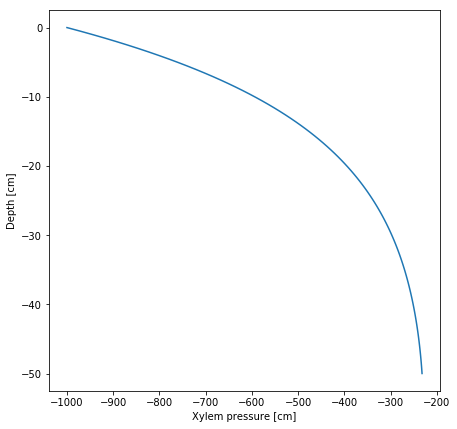

In [3]:
# Analytical solution
c = 2*a*pi*kr/kz
p_r = lambda z: p_s + d[0]*exp(sqrt(c)*z) + d[1]*exp(-sqrt(c)*z)

# Boundary conditions
AA = np.array([[1,1], [sqrt(c)*exp(sqrt(c)*(-L)), -sqrt(c)*exp(-sqrt(c)*(-L))] ]) 
bb = np.array([p0-p_s, -1]) 
d = np.linalg.solve(AA, bb) 

# Plot results
fig=plt.figure(figsize=(7, 7))
za_ = np.linspace(0,-L,100)
pr = list(map(p_r, za_))
plt.plot(pr,za_)
plt.xlabel("Xylem pressure [cm]")
plt.ylabel("Depth [cm]")
plt.show()

### Benchmark M3.2: Root System

In the following we will give a small static root system which is eight days old described by nodes (in cm) and segments (two node indices) which is located in a static soil with constant soil matric potential. For each node we give the age (in days), and for each segment the type which is either 0 for tap root or 1 for lateral root. Furthermore, the radius is constant for tap, and lateral roots (in cm). 

In [4]:
nodes = np.array([ [0.00,0.00,-3.00], [-0.00,-0.01,-3.48], [-0.85,0.48,-3.71], [-1.69,0.99,-3.90], [-2.58,1.32,-4.21], [-3.48,1.67,-4.49], [-4.38,2.00,-4.77], [-5.24,2.40,-5.09], [-6.08,2.82,-5.42], [-6.93,3.27,-5.69], [-6.96,3.29,-5.70], [-0.00,0.01,-3.97], [0.20,-0.95,-4.20], [0.43,-1.88,-4.49], [0.65,-2.81,-4.77], [0.84,-3.75,-5.06], [1.04,-4.70,-5.31], [1.27,-5.64,-5.54], [1.43,-6.58,-5.84], [1.48,-6.91,-5.94], [-0.01,0.03,-4.45], [0.75,0.68,-4.48], [1.52,1.32,-4.50], [2.30,1.94,-4.46], [3.07,2.58,-4.41], [3.88,3.16,-4.46], [4.73,3.69,-4.50], [5.34,4.05,-4.53], [-0.03,0.06,-4.97], [-0.73,0.63,-5.40], [-1.46,1.20,-5.79], [-2.15,1.80,-6.18], [-2.76,2.48,-6.59], [-3.16,3.16,-7.21], [-3.63,3.90,-7.64], [-0.06,0.07,-5.42], [0.07,1.04,-5.61], [0.23,2.00,-5.82], [0.46,2.93,-6.11], [0.72,3.85,-6.40], [0.99,4.77,-6.69], [1.06,5.11,-6.78], [-0.10,0.08,-5.96], [0.35,0.90,-6.31], [0.80,1.72,-6.65], [1.23,2.55,-7.01], [1.62,3.41,-7.34], [1.70,3.58,-7.41], [-0.14,0.10,-6.46], [0.05,-0.81,-6.83], [0.29,-1.72,-7.18], [0.43,-2.62,-7.59], [0.50,-3.12,-7.84], [-0.19,0.12,-7.02], [0.32,0.98,-7.03], [0.82,1.84,-6.95], [1.07,2.23,-6.88], [-0.23,0.17,-7.56], [0.68,-0.18,-7.80], [1.12,-0.35,-7.93], [-0.24,0.21,-8.14], [-0.01,0.36,-8.22], [-0.25,0.24,-8.69], [-0.24,0.25,-9.25], [-0.24,0.26,-9.71], [-0.26,0.26,-10.09], [-0.28,0.25,-10.57], [-0.26,0.24,-11.05], [-0.26,0.21,-11.58], [-0.25,0.19,-12.06], [-0.25,0.17,-12.55], [-0.23,0.15,-13.00], [-0.23,0.12,-13.46], [-0.22,0.12,-13.99], [-0.21,0.15,-14.54], [-0.19,0.20,-15.07], [-0.17,0.24,-15.60], [-0.17,0.31,-16.17], [-0.15,0.36,-16.64], [-0.12,0.43,-17.18], [-0.11,0.48,-17.70], [-0.07,0.52,-18.23], [-0.06,0.53,-18.53] ])
seg = np.array([ [0,1], [1,11], [11,20], [20,28], [28,35], [35,42], [42,48], [48,53], [53,57], [57,60], [60,62], [62,63], [63,64], [64,65], [65,66], [66,67], [67,68], [68,69], [69,70], [70,71], [71,72], [72,73], [73,74], [74,75], [75,76], [76,77], [77,78], [78,79], [79,80], [80,81], [81,82], [1,2], [2,3], [3,4], [4,5], [5,6], [6,7], [7,8], [8,9], [9,10], [11,12], [12,13], [13,14], [14,15], [15,16], [16,17], [17,18], [18,19], [20,21], [21,22], [22,23], [23,24], [24,25], [25,26], [26,27], [28,29], [29,30], [30,31], [31,32], [32,33], [33,34], [35,36], [36,37], [37,38], [38,39], [39,40], [40,41], [42,43], [43,44], [44,45], [45,46], [46,47], [48,49], [49,50], [50,51], [51,52], [53,54], [54,55], [55,56], [57,58], [58,59], [60,61] ])
age = np.array([ 8.00,7.76,7.52,7.29,7.03,6.80,6.53,6.28,6.00,5.73,5.43,5.16,4.87,4.64,4.44,4.20,3.95,3.68,3.43,3.17,2.94,2.70,2.42,2.14,1.85,1.57,1.27,1.02,0.73,0.45,0.16,-0.00,2.29,2.02,1.74,1.43,1.11,0.77,0.41,0.01,0.00,2.04,1.77,1.48,1.18,0.85,0.51,0.14,0.00,1.78,1.51,1.22,0.92,0.60,0.26,0.00,1.51,1.24,0.96,0.66,0.34,0.00,1.28,1.01,0.73,0.43,0.12,0.00,0.97,0.69,0.39,0.07,0.00,0.72,0.45,0.17,0.00,0.41,0.14,0.00,0.13,0.00,0.00 ])
types = np.array([ 1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2 ])
a_tap = 0.2 # tap root radius (cm)
a_lateral = 0.1 # lateral root radius (cm)

We can visualize this small root system by the following script, where colors denote the root type:

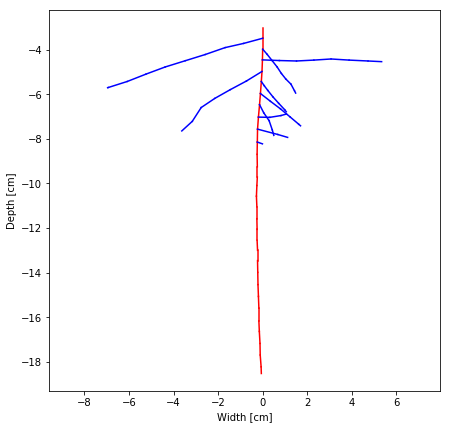

In [5]:
fig=plt.figure(figsize=(7, 7))
cols = ['r','b'] 
for i,s in enumerate(seg): 
    n1 = nodes[s[0]]
    n2 = nodes[s[1]]
    plt.plot([n1[0], n2[0]], [n1[2], n2[2]], cols[types[i]-1])    
plt.axis('equal')
plt.xlabel("Width [cm]")
plt.ylabel("Depth [cm]")
plt.show()

For benchmark M3.2(a) we first neglect root age and define static conductivities according to Javaux et al. (2008), and define boundary conditions as in Benchmark M3.1: At the root collar we assume -1000 cm pressure head located at node index 0, and a no-flux boundary condition at the root tips. The soil is assumed to be static with a matric potential of -200 cm pressure head. 

Aim is to calculate the pressure at the segments or nodes. 

In [6]:
kz = 4.32e-2      # axial conductivity (cm^3 / day) 
kr = 1.728e-4     # radial conductivity (1 / day) 
p_s = -200        # static soil matric potiential (cm) 
p0 = -1000        # dirichlet bc at top (cm)

Since there is no analytical solution available to this problem, we can validate numerical codes by inter-comparison. The root collar is at node index 0, root tip node indices are given by:

In [7]:
def isTip(nid,seg):
    for s in seg[:,0]:
        if s==nid:
            return False
    return True

tipsI = ""
for i in range(0, len(nodes)):
    if isTip(i,np.array(seg)): 
        tipsI += str(i)+","    
print("tip node indices= ["+tipsI[:-1]+"]")                    

tip node indices= [10,19,27,34,41,47,52,56,59,61,82]


In Benchmark M3.2(b) we are interested in the influence of age dependent radial and axial conductivities. We define these conductivities as: 

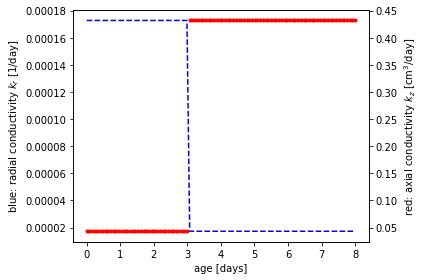

In [8]:
kz0, kz1 = 4.32e-2, 4.32e-1, # (cm^3 / day) 
kr0, kr1 = 1.728e-4, 1.728e-5 # (1 / day)
kz = lambda age: kz0*(age<=3)+kz1*(age>3)
kr = lambda age: kr0*(age<=3)+kr1*(age>3)

# Plot function
age_ = np.linspace(0,8,100)
fig, ax1 = plt.subplots()
ax1.plot(age_,list(map(kr, age_)), "b--")
ax1.set_xlabel("age [days]")
ax1.set_ylabel("blue: radial conductivity $k_r$ [1/day]")
ax2 = ax1.twinx()
ax2.plot(age_,list(map(kz, age_)), "r.")
ax2.set_ylabel("red: axial conductivity $k_z$ [cm$^3$/day]")
fig.tight_layout()
plt.show()

## Comparison to numerical solutions

We validate various numerical codes by solving the benchmarking problems. In the following we link to notebooks already containing Benchmark M3.1, M3.2, and M3.3

* [Homegrown Python Code from Schnepf et al. 2018](Xylem flux - Python code.ipynb)
* [Dumux](Xylem flux - Dumux.ipynb)

### Benchmark M3.1 

For an automatic comparison of the numerical results, save the results in a text file with two lines, containing comma separated depth values (cm) in the first line, and pressure head (cm) in the second, located in the folder `/xylem_flux/b1/simulatorname`.

TODO m -> cm, convert files, change below (remove *100)

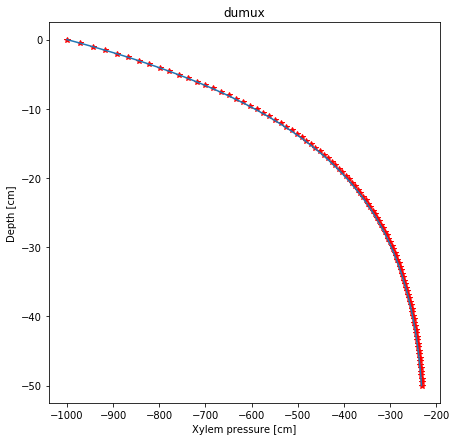

From -1000.0 to -230.88581485728847 cm pressure head
N =100
R² =0.9999104736968015


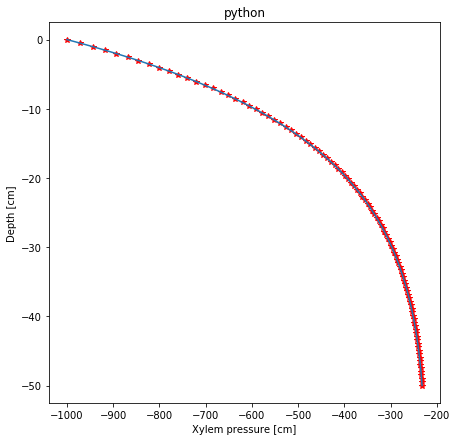

From -1000.0 to -232.05687069550083 cm pressure head
N =100
R² =0.9999999862532619


In [13]:
for dirname, dirnames, filenames in os.walk('xylem_flux/b1/.'):
    filenames.sort()
    for i,f in enumerate(filenames):
        try:
            data = np.loadtxt("xylem_flux/b1/"+f,delimiter=',')
            fig=plt.figure(figsize=(7, 7))    
            plt.plot(data[1,:],data[0,:]*100,'r*') # numeric solution
            plt.xlabel("Xylem pressure [cm]")
            plt.ylabel("Depth [cm]")
            plt.title(f)        
            plt.plot(pr,za_) # analytical solution
            pr_ = list(map(p_r, data[0,:]*100))            
            plt.show()
            # calculate R^2
            n = data.shape[1]
            r = 1 - ( np.sum(np.square(pr_-data[1,:])) / (np.sum(np.square(pr_))-np.square(np.sum(pr_))/n) )    
            print("From", min(data[1,:]), "to", max(data[1,:]), "cm pressure head")
            print("N =" + str(n))
            print("R² =" + str(r))
        except: 
            print("Something went wrong with file "+f)    

### Benchmark M3.2(a)

For an inter-comparison of the numerical results save the results in a text file with two lines, containing comma separated depth values (cm) in the first line, and pressure head (cm) in the second line. Locate the file in the folder `/xylem_flux/b2/simulatorname`.

1. python (r*):
from  -1000.0 to -268.05952886405896  cm pressure head

2. dumux (g*):
from  -1000.0 to -262.26403223751277  cm pressure head



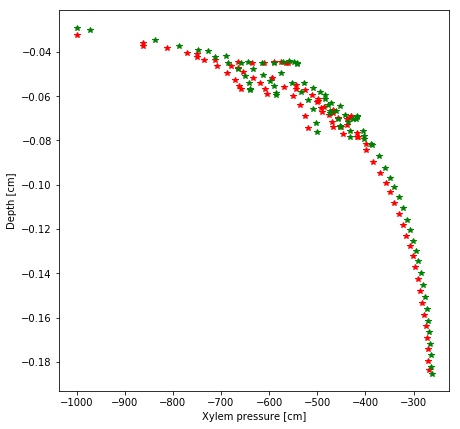

In [12]:
fig=plt.figure(figsize=(7, 7))
col = ["r*", "g*", "b*","rv", "gv", "bv"]
for dirname, dirnames, filenames in os.walk('xylem_flux/b2/.'):
    for i,f in enumerate(filenames):
        try:
            data = np.loadtxt("xylem_flux/b2/"+f,delimiter=',')        
            print(str(i+1)+". "+f+" ("+col[i]+"):")
            print("from ", min(data[1,:]), "to", max(data[1,:]), " cm pressure head\n")        
            plt.plot(data[1,:],data[0,:],col[i])
        except:
            print("Something went wrong with file "+f)                
            
plt.xlabel("Xylem pressure [cm]")
plt.ylabel("Depth [cm]")        
plt.show()    

### Benchmark M3.2(b)

For an inter-comparison of the numerical results save the results in a text file with two lines, containing comma separated depth values (cm) in the first line, and pressure head (cm) in the second line. Locate the file in the folder `/xylem_flux/b3/simulatorname`.

1. python (r*):
from  -1000.0 to -199.74711963546272  cm pressure head

2. dumux (g*):
from  -1000.0 to -201.95511595310907  cm pressure head



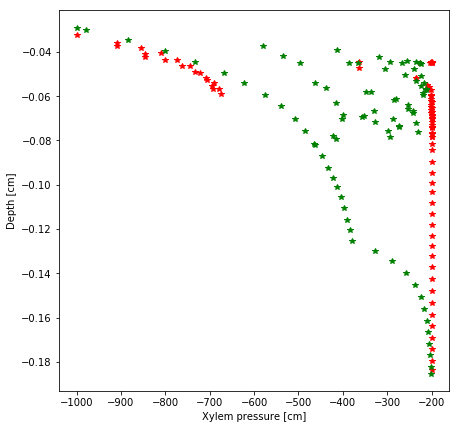

In [14]:
fig=plt.figure(figsize=(7, 7))
col = ["r*", "g*", "b*","rv", "gv", "bv"]
for dirname, dirnames, filenames in os.walk('xylem_flux/b3/.'):
    filenames.sort()
    for i,f in enumerate(filenames):
        try:
            data = np.loadtxt("xylem_flux/b3/"+f,delimiter=',')        
            print(str(i+1)+". "+f+" ("+col[i]+"):")
            print("from ", min(data[1,:]), "to", max(data[1,:]), " cm pressure head\n")        
            plt.plot(data[1,:],data[0,:],col[i])
        except:
            print("Something went wrong with file "+f)      
    
plt.xlabel("Xylem pressure [cm]")
plt.ylabel("Depth [cm]")        
plt.show()

## References

Doussan, C., Pierret, A., Garrigues, E., and Pages, L. (2006). Water uptake by plant roots: II - Modelling of water transfer in the soil root-system with explicit account of flow within the root system - comparison with experiments. *Plant and Soil*, 283(1-2):99–117.

Roose, T. and Fowler, A. C. (2004). A model for water uptake by plant roots. *Journal of Theoretical Biology*, 228(2):155–171.

Schnepf, A., Leitner, D., Landl, M., Lobet, G., Mai, T.H., Morandage S., Sheng, C., Zoerner, M., Vanderborght, J., Vereecken, H. (2018) CRootBox: a structural-functional modelling framework for root systems. *Annals of Botany*, 121 (5), 1033-1053
